In [2]:
from tools import get_B_projections, get_active_set
from pynep.io import load_nep, dump_nep

nep_file = "nep.txt"
traj = load_nep("train.xyz", ftype="exyz")

B_projections, B_projections_struct_index = get_B_projections(traj, nep_file)

Elements in the NEP potential: ['Na', 'Cl']
Calculating B projections...


100%|██████████| 4725/4725 [00:29<00:00, 160.53it/s]


Shape of the B matrix:
Na: (119999, 960)
Cl: (119999, 960)


In [3]:
active_set_inv, active_set_struct = get_active_set(
    B_projections, B_projections_struct_index
)

Performing MaxVol...
Maxvol Speed: 330 iters/s
Batch 0: adding 960 envs. 
Maxvol Speed: 369 iters/s
Batch 1: adding 545 envs. 
Maxvol Speed: 364 iters/s
Batch 2: adding 357 envs. 
Maxvol Speed: 348 iters/s
Batch 3: adding 331 envs. 
Maxvol Speed: 354 iters/s
Batch 4: adding 316 envs. 
Maxvol Speed: 353 iters/s
Batch 5: adding 319 envs. 
Maxvol Speed: 322 iters/s
Batch 6: adding 251 envs. 
Maxvol Speed: 313 iters/s
Batch 7: adding 196 envs. 
Maxvol Speed: 310 iters/s
Batch 8: adding 112 envs. 
Maxvol Speed: 143 iters/s
Batch 9: adding 3 envs. 
Maxvol Speed: 203 iters/s
Batch 10: adding 19 envs. 
Maxvol Speed: 267 iters/s
Batch 11: adding 61 envs. 
Refinement round 0: 0 envs out of active set. Max gamma = 0.9997219572219311
Refinement done.
Shape of the active set:
Na: (960, 960)
Maxvol Speed: 440 iters/s
Batch 0: adding 960 envs. 
Maxvol Speed: 397 iters/s
Batch 1: adding 572 envs. 
Maxvol Speed: 415 iters/s
Batch 2: adding 367 envs. 
Maxvol Speed: 399 iters/s
Batch 3: adding 326 envs. 

In [ ]:
from tools import get_gamma
from pynep.io import load_nep, dump_nep

nep_file = "nep.txt"
traj = load_nep("train.xyz", ftype="exyz")

get_gamma(traj, nep_file, "active_set.asi")

from ase.io import write

write("with_gamma.xyz", traj, write_results=False)

out_traj = [atoms for atoms in traj if atoms.arrays["gamma"].max() > 1]
dump_nep("large_gamma.xyz", out_traj, ftype="exyz")

Calculating gamma...


100%|██████████| 4725/4725 [00:38<00:00, 123.68it/s]


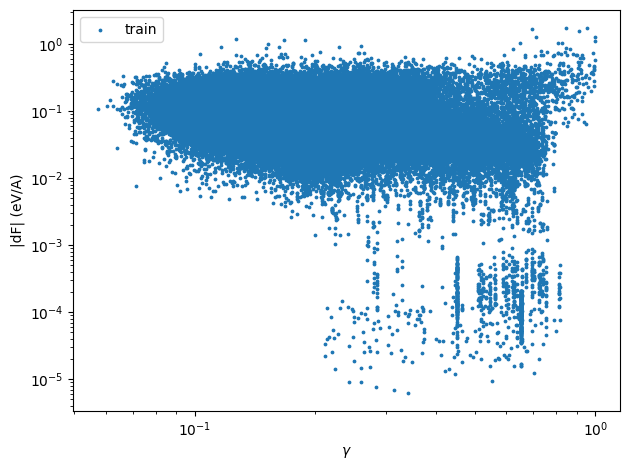

In [4]:
import numpy as np
from tqdm import tqdm
from pynep.calculate import NEP
from ase.io import read
import matplotlib.pyplot as plt
from asi_io import load_asi

nep_file = "nep.txt"
calc = NEP(nep_file)

active_set_inverse = load_asi("active_set.asi")


def get_gamma_dF(file):
    traj = read(file, index=":")
    gamma = {k: [] for k in active_set_inverse.keys()}
    dF = {k: [] for k in active_set_inverse.keys()}
    phase = {k: [] for k in active_set_inverse.keys()}

    print("Calculating gamma...")

    for atoms in tqdm(traj):
        dft_F = atoms.arrays["force"]
        calc.calculate(atoms, ["B_projection"])
        B_projection = calc.results["B_projection"]
        nep_F = calc.results["forces"]
        F_error = np.linalg.norm(dft_F - nep_F, axis=1)
        for e in active_set_inverse.keys():
            index = [
                ii for ii in range(len(atoms)) if atoms.get_chemical_symbols()[ii] == e
            ]
            g = B_projection[index] @ active_set_inverse[e]
            g = np.max(np.abs(g), axis=1)
            gamma[e].extend(g)
            dF[e].extend(F_error[index])
            phase[e].extend([atoms.info["config_type"]] * len(index))

    return gamma, dF, phase


gamma, dF, phase = get_gamma_dF("train.xyz")
plt.scatter(gamma["Na"], dF["Na"], s=3, label="train")


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel(r"$\gamma$")
plt.ylabel("|dF| (eV/A)")
plt.tight_layout()
plt.legend()
plt.savefig("gamma-dF.png", transparent=False)